# Ensemble classifiers

In [1]:
import statistics
import pandas as pd
import numpy as np
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_blobs
from classification_utils import *
from sklearn.model_selection import cross_validate
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
import statistics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.decomposition import PCA
import pickle
from sklearn.metrics import RocCurveDisplay

## Load Data

The only preprocessing step done is the one-hot-encoding of the **Lang** feature.

In [2]:
data = pd.read_csv("../dataset/cleaned_user_profiles.csv", index_col=0)
data = data.join(pd.get_dummies(data["lang"]))
train_set, test_set, train_label, test_label = prepare_data(data)

Classification features : ['created_at', 'statuses_count', 'avg_length', 'avg_special_chars', 'urls_ratio', 'mentions_ratio', 'hashtags_ratio', 'reply_count_mean', 'reply_count_std', 'favorite_count_mean', 'favorite_count_std', 'favorite_count_entropy', 'retweet_count_mean', 'retweet_count_std', 'retweet_count_entropy', 'ar', 'da', 'de', 'el', 'en', 'es', 'fil', 'fr', 'id', 'it', 'ja', 'ko', 'nl', 'pl', 'pt', 'ru', 'sv', 'tr', 'zh']


## Bagging

Bagging methods form a class of algorithms which build several instances of a black-box estimator on random subsets of the original training set and then aggregate their individual predictions to form a final prediction. These methods are used as a way to reduce the variance of a base estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

We will run a Grid-Search Cross-Validation over several parameters:
- **n_estimators**: The number of base estimators in the ensemble.
- **max_features**: The number of features to draw from X to train each base estimator.
- **max_samples**: The number of samples to draw from X to train each base estimator.

In [3]:
param_grid = {
                'n_estimators': np.arange(2, 40, 1),
                'max_features': [0.7, 0.8, 0.85, 0.9, 1.0],
                'max_samples': [0.7, 0.8, 0.85, 0.9, 1.0]
             }

bagging = BaggingClassifier()

grid = GridSearchCV(
    bagging,
    param_grid,
    cv=3,
    scoring='accuracy',
    return_train_score=False,
    verbose=1,
    n_jobs=-1
)

grid.fit(train_set, train_label)

Fitting 3 folds for each of 950 candidates, totalling 2850 fits


GridSearchCV(cv=3, estimator=BaggingClassifier(), n_jobs=-1,
             param_grid={'max_features': [0.7, 0.8, 0.85, 0.9, 1.0],
                         'max_samples': [0.7, 0.8, 0.85, 0.9, 1.0],
                         'n_estimators': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39])},
             scoring='accuracy', verbose=1)

In [4]:
bagging = grid.best_estimator_
bagging

BaggingClassifier(max_features=0.7, max_samples=0.85, n_estimators=37)

### Print Metrics

In [5]:
train_pred = bagging.predict(train_set)
test_pred = bagging.predict(test_set)

print_metrics(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.9987585350713842
Accuracy test set  0.893136403127715
Precision train set  0.9987603554140391
Recall train set  0.9987585350713842
F1 score train set  0.9987584559161745
Support train set  (array([0.99973447, 0.99790161]), array([0.99761526, 0.99976641]), array([0.99867374, 0.99883314]), array([3774, 4281], dtype=int64))


In [6]:
report_scores(test_label,test_pred)

              precision    recall  f1-score   support

        <=50       0.97      0.79      0.87      1618
         >50       0.84      0.98      0.91      1835

    accuracy                           0.89      3453
   macro avg       0.91      0.89      0.89      3453
weighted avg       0.90      0.89      0.89      3453



### Confusion Matrix

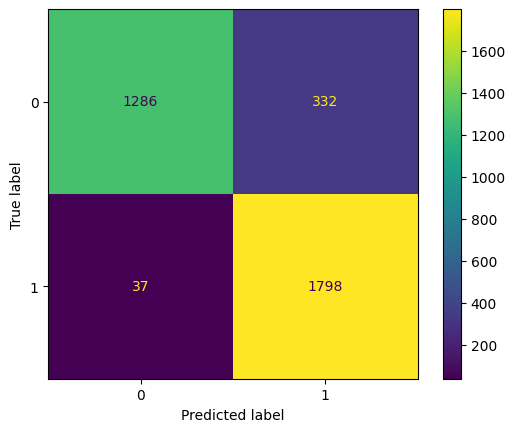

In [7]:
predictions = bagging.predict(test_set)

cm = confusion_matrix(test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

### ROC-Curve

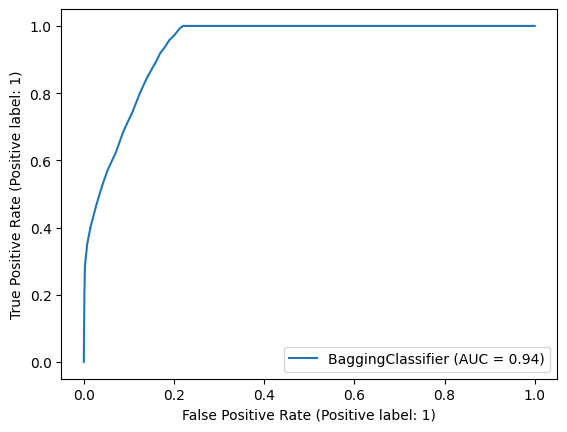

In [8]:
RocCurveDisplay.from_estimator(bagging, test_set, test_label)
plt.show()

### PCA Blobs

In [9]:
pca = PCA(n_components=2)
test_set_reduced = pca.fit_transform(test_set.values)

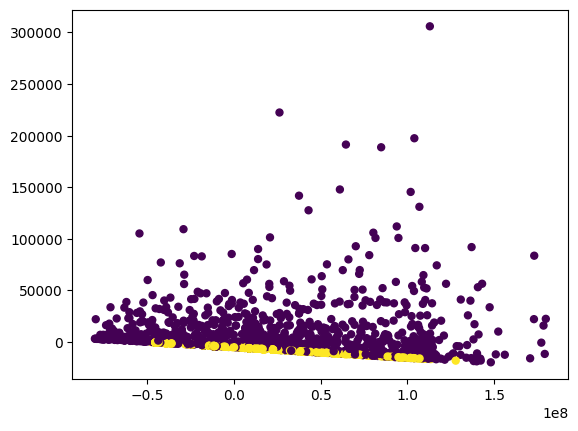

In [10]:
#true labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_label, s=25);

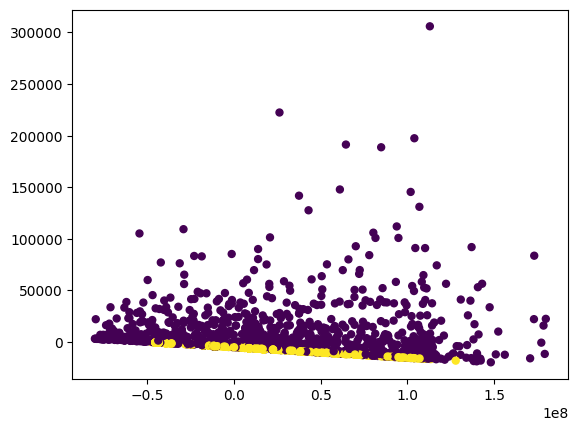

In [11]:
#predicted labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_pred, s=25);

## Extremely Randomized Trees

A meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

We will run a Grid-Search Cross-Validation over several parameters:
- **max_features**: The number of features to consider when looking for the best split.
- **min_sample_split**: The minimum number of samples required to split an internal node.
- **min_samples_leaf**: The minimum number of samples required to be at a leaf node.
- **n_estimators**: The number of trees in the forest.
- **ccp_alpha**: Complexity parameter used for Minimal Cost-Complexity Pruning.
- **min_weight_fraction_leaf**: The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node.
- **criterion**: The function to measure the quality of a split.

In [12]:
param_grid = {'max_features': ['sqrt', 'log2', None],
              'min_samples_split': [1, 2, 3, 4, 5],
              'min_samples_leaf': [1, 2, 3, 4],
              'n_estimators': np.arange(50, 200, 10),
              'ccp_alpha': [0, 0.1, 0.05, 0.3, 0.5],
              'min_weight_fraction_leaf': [0, 0.1, 0.05, 0.3, 0.5],
              'criterion' :['gini', 'entropy', 'log_loss']
             }

ert = ExtraTreesClassifier()

grid = GridSearchCV(
    ert,
    param_grid,
    cv=3,
    scoring='accuracy',
    return_train_score=False,
    verbose=1,
    n_jobs=-1
)

grid.fit(train_set, train_label)

Fitting 3 folds for each of 67500 candidates, totalling 202500 fits


C:\Users\espos\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
40500 fits failed out of a total of 202500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40500 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\espos\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\espos\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(

GridSearchCV(cv=3, estimator=ExtraTreesClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0, 0.1, 0.05, 0.3, 0.5],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [1, 2, 3, 4, 5],
                         'min_weight_fraction_leaf': [0, 0.1, 0.05, 0.3, 0.5],
                         'n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170,
       180, 190])},
             scoring='accuracy', verbose=1)

In [13]:
ert = grid.best_estimator_
ert

ExtraTreesClassifier(ccp_alpha=0, criterion='entropy', max_features=None,
                     min_samples_leaf=2, min_samples_split=5,
                     min_weight_fraction_leaf=0, n_estimators=50)

### Print Metrics

In [14]:
train_pred = ert.predict(train_set)
test_pred = ert.predict(test_set)

print_metrics(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.9998758535071384
Accuracy test set  0.8911091804228207
Precision train set  0.9998758824997804
Recall train set  0.9998758535071384
F1 score train set  0.999875852531255
Support train set  (array([1.        , 0.99976646]), array([0.99973503, 1.        ]), array([0.9998675 , 0.99988322]), array([3774, 4281], dtype=int64))


In [15]:
report_scores(test_label,test_pred)

              precision    recall  f1-score   support

        <=50       0.96      0.80      0.87      1618
         >50       0.85      0.97      0.90      1835

    accuracy                           0.89      3453
   macro avg       0.90      0.89      0.89      3453
weighted avg       0.90      0.89      0.89      3453



### Confusion Matrix

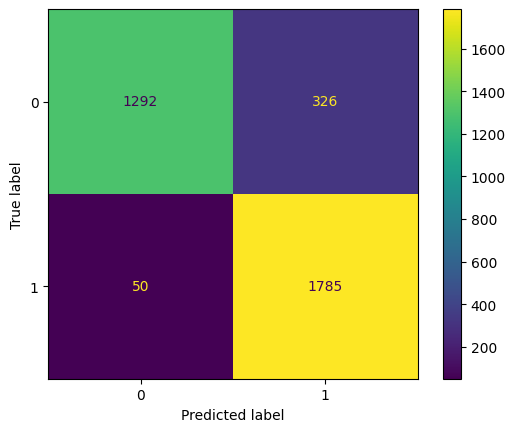

In [16]:
predictions = ert.predict(test_set)

cm = confusion_matrix(test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

### ROC-Curve

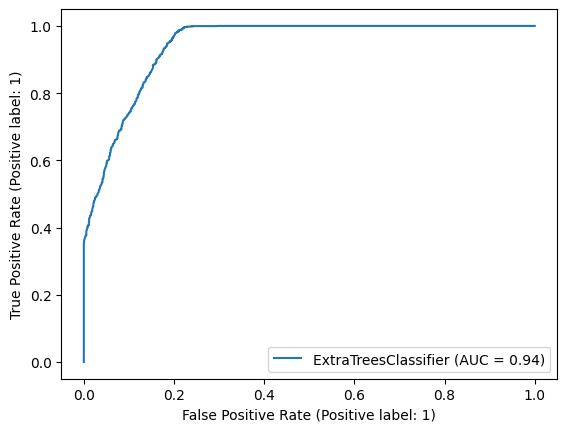

In [17]:
RocCurveDisplay.from_estimator(ert, test_set, test_label)
plt.show()

### PCA Blobs

In [18]:
pca = PCA(n_components=2)
test_set_reduced = pca.fit_transform(test_set.values)

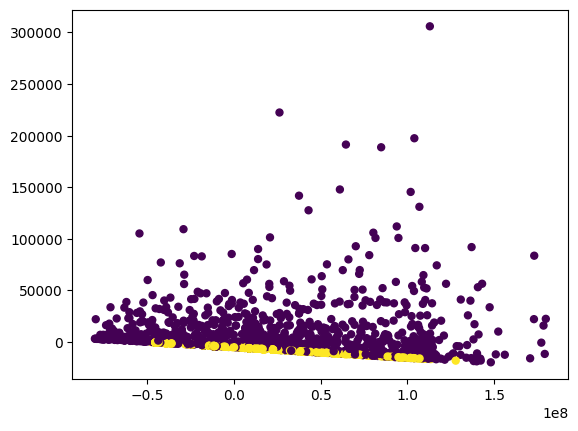

In [19]:
#true labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_label, s=25);

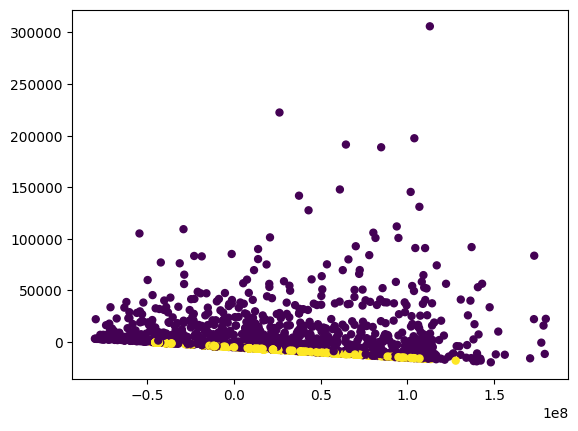

In [20]:
#predicted labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_pred, s=25);

## AdaBoost

A meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

We will run a Grid-Search Cross-Validation over several parameters:
- **n_estimators**: The maximum number of estimators at which boosting is terminated.
- **learnign_rate**: Weight applied to each classifier at each boosting iteration.
- **algorithm**: If ‘SAMME.R’ then use the SAMME.R real boosting algorithm. estimator must support calculation of class probabilities. If ‘SAMME’ then use the SAMME discrete boosting algorithm. The SAMME.R algorithm typically converges faster than SAMME, achieving a lower test error with fewer boosting iterations.

In [21]:
param_grid = {'n_estimators': np.arange(5, 100, 5),
              'learning_rate': [0.8, 0.9, 1.0, 1.1, 1.2],
              'algorithm': ['SAMME', 'SAMME.R'],
             }

ada = AdaBoostClassifier()

grid = GridSearchCV(
    ada,
    param_grid,
    cv=3,
    scoring='accuracy',
    return_train_score=False,
    verbose=1,
    n_jobs=-1
)

grid.fit(train_set, train_label)

Fitting 3 folds for each of 190 candidates, totalling 570 fits


GridSearchCV(cv=3, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.8, 0.9, 1.0, 1.1, 1.2],
                         'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])},
             scoring='accuracy', verbose=1)

In [22]:
ada = grid.best_estimator_
ada

AdaBoostClassifier(learning_rate=0.9, n_estimators=40)

## Print Metrics

In [23]:
train_pred = ada.predict(train_set)
test_pred = ada.predict(test_set)

print_metrics(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.8986964618249534
Accuracy test set  0.893136403127715
Precision train set  0.9125687697286295
Recall train set  0.8986964618249534
F1 score train set  0.897154889557268
Support train set  (array([0.99071002, 0.84368181]), array([0.79120297, 0.99345947]), array([0.87978786, 0.91246514]), array([3774, 4281], dtype=int64))


In [24]:
report_scores(test_label,test_pred)

              precision    recall  f1-score   support

        <=50       0.99      0.78      0.87      1618
         >50       0.84      0.99      0.91      1835

    accuracy                           0.89      3453
   macro avg       0.91      0.89      0.89      3453
weighted avg       0.91      0.89      0.89      3453



### Confusion Matrix

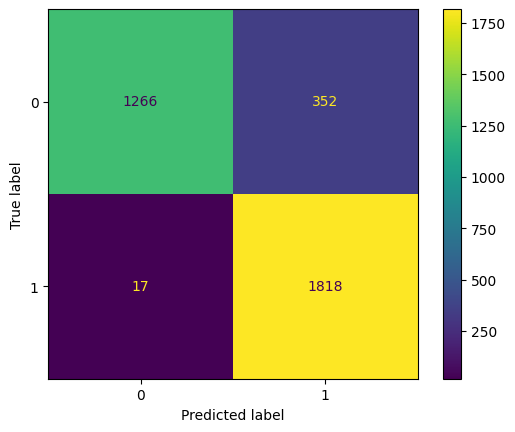

In [25]:
predictions = ada.predict(test_set)

cm = confusion_matrix(test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

### ROC-Curve

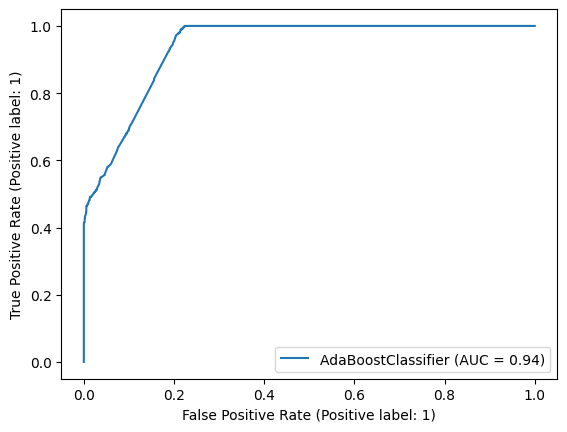

In [26]:
RocCurveDisplay.from_estimator(ada, test_set, test_label)
plt.show()

### PCA Blobs

In [27]:
pca = PCA(n_components=2)
test_set_reduced = pca.fit_transform(test_set.values)

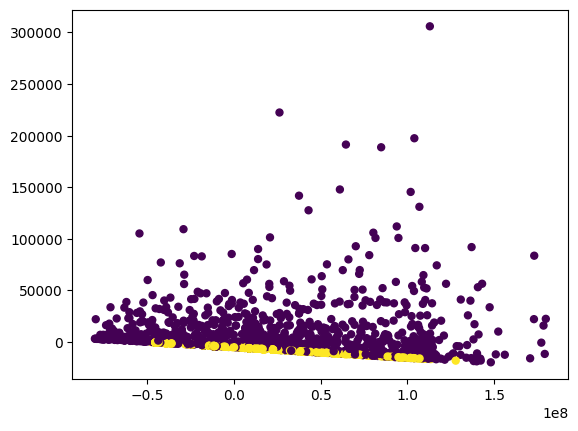

In [28]:
#true labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_label, s=25);

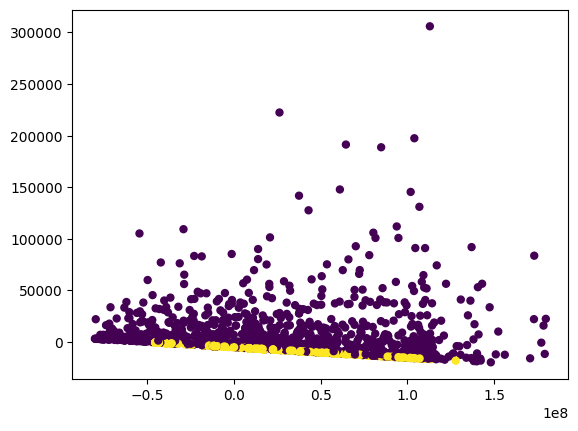

In [29]:
#predicted labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_pred, s=25);

## Gradient Tree Boosting

This algorithm builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage n_classes_ regression trees are fit on the negative gradient of the loss function.

We will run the model with default parameters without doing a Grid Search, since the fact that this model is not mandatory, and due the timing limitation.

In [30]:
gbc = GradientBoostingClassifier()
gbc.fit(train_set, train_label)
gbc

GradientBoostingClassifier()

## Print Metrics

In [31]:
train_pred = gbc.predict(train_set)
test_pred = gbc.predict(test_set)

print_metrics(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.9070142768466791
Accuracy test set  0.9000868809730669
Precision train set  0.9200666727566231
Recall train set  0.9070142768466791
F1 score train set  0.9056918272713171
Support train set  (array([0.99671593, 0.85249501]), array([0.80418654, 0.9976641 ]), array([0.89015985, 0.91938435]), array([3774, 4281], dtype=int64))


In [32]:
report_scores(test_label,test_pred)

              precision    recall  f1-score   support

        <=50       0.99      0.79      0.88      1618
         >50       0.84      1.00      0.91      1835

    accuracy                           0.90      3453
   macro avg       0.92      0.89      0.90      3453
weighted avg       0.91      0.90      0.90      3453



### Confusion Matrix

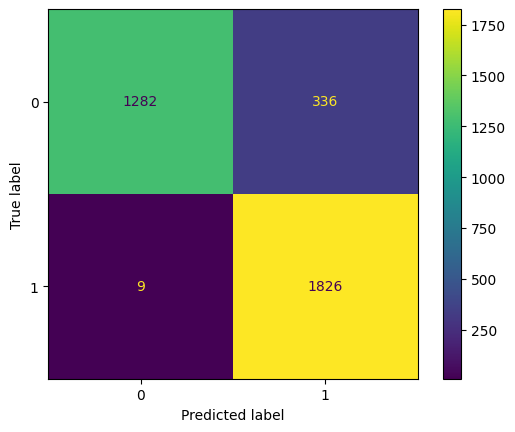

In [33]:
predictions = gbc.predict(test_set)

cm = confusion_matrix(test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

### ROC-Curve

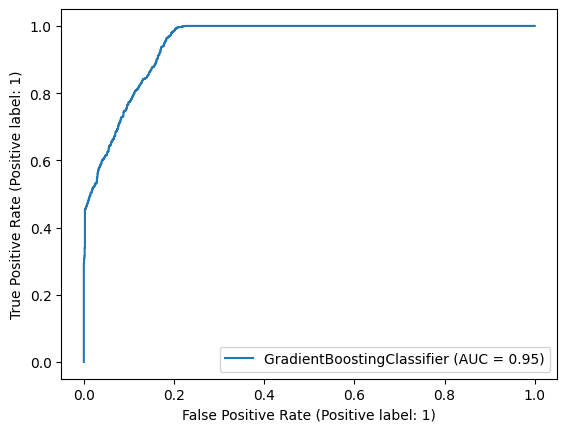

In [34]:
RocCurveDisplay.from_estimator(gbc, test_set, test_label)
plt.show()

### PCA Blobs

In [35]:
pca = PCA(n_components=2)
test_set_reduced = pca.fit_transform(test_set.values)

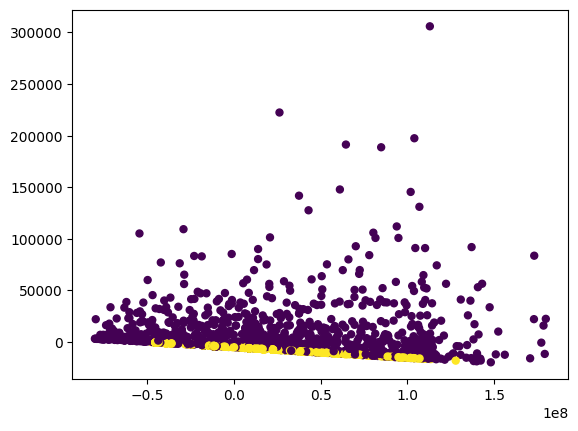

In [36]:
#true labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_label, s=25);

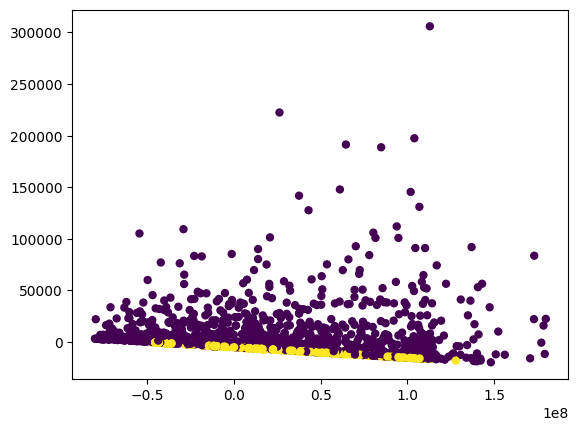

In [37]:
#predicted labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_pred, s=25);

##  Histogram-Based Gradient Boosting

During training, the tree grower learns at each split point whether samples with missing values should go to the left or right child, based on the potential gain. When predicting, samples with missing values are assigned to the left or right child consequently.

We will run the model with default parameters without doing a Grid Search, since the fact that this model is not mandatory, and due the timing limitation.

In [38]:
hgbc = HistGradientBoostingClassifier()
hgbc.fit(train_set, train_label)
hgbc

HistGradientBoostingClassifier()

## Print Metrics

In [39]:
train_pred = hgbc.predict(train_set)
test_pred = hgbc.predict(test_set)

print_metrics(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.9524518932340161
Accuracy test set  0.8951636258326093
Precision train set  0.9563136561402792
Recall train set  0.9524518932340161
F1 score train set  0.952200906634001
Support train set  (array([0.99970528, 0.91806092]), array([0.89878113, 0.99976641]), array([0.94656063, 0.95717321]), array([3774, 4281], dtype=int64))


In [40]:
report_scores(test_label,test_pred)

              precision    recall  f1-score   support

        <=50       0.97      0.80      0.88      1618
         >50       0.85      0.98      0.91      1835

    accuracy                           0.90      3453
   macro avg       0.91      0.89      0.89      3453
weighted avg       0.91      0.90      0.89      3453



### Confusion Matrix

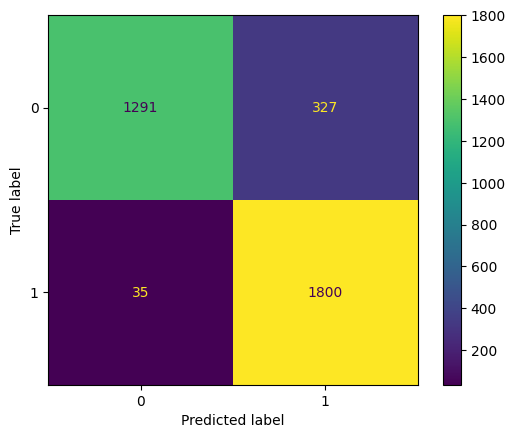

In [41]:
predictions = hgbc.predict(test_set)

cm = confusion_matrix(test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

### ROC-Curve

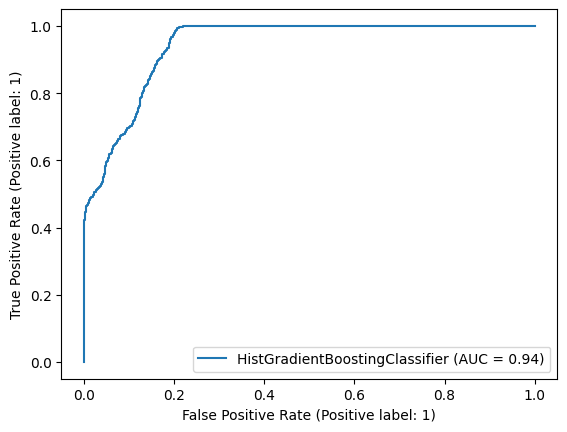

In [42]:
RocCurveDisplay.from_estimator(hgbc, test_set, test_label)
plt.show()

### PCA Blobs

In [43]:
pca = PCA(n_components=2)
test_set_reduced = pca.fit_transform(test_set.values)

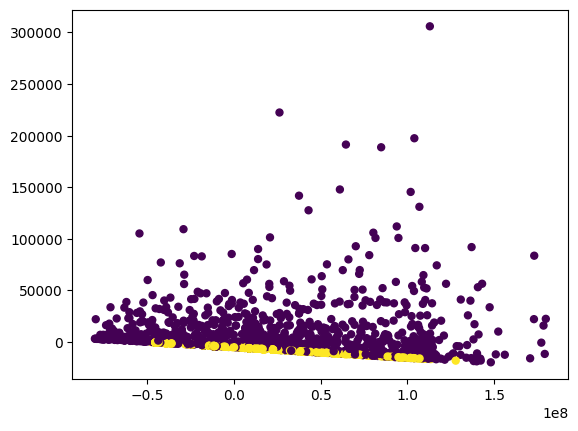

In [44]:
#true labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_label, s=25);

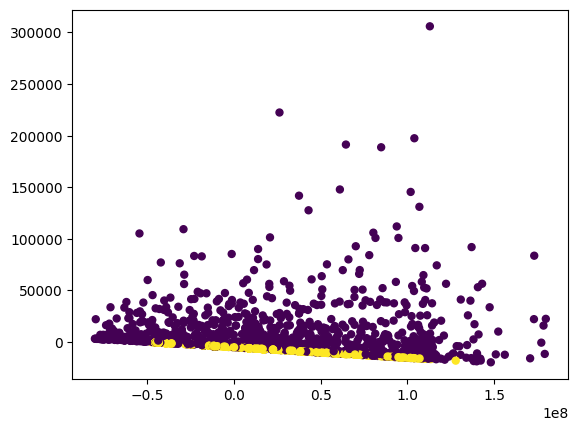

In [45]:
#predicted labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_pred, s=25);

## Save models

In [46]:
with open("../models_checkpoints/bagging_lang.bin", "wb") as f:
    pickle.dump(bagging, f)
    
with open("../models_checkpoints/adaboost_lang.bin", "wb") as f:
    pickle.dump(ada, f)

## Removed "lang" attribute for classification

### Load Data

In [47]:
data = pd.read_csv("../dataset/cleaned_user_profiles.csv", index_col=0)
data.drop(columns=['lang'])
train_set, test_set, train_label, test_label = prepare_data(data)

Classification features : ['created_at', 'statuses_count', 'avg_length', 'avg_special_chars', 'urls_ratio', 'mentions_ratio', 'hashtags_ratio', 'reply_count_mean', 'reply_count_std', 'favorite_count_mean', 'favorite_count_std', 'favorite_count_entropy', 'retweet_count_mean', 'retweet_count_std', 'retweet_count_entropy']


## Bagging

In [48]:
param_grid = {
                'n_estimators': np.arange(2, 40, 1),
                'max_features': [0.7, 0.8, 0.85, 0.9, 1.0],
                'max_samples': [0.7, 0.8, 0.85, 0.9, 1.0]
             }

bagging = BaggingClassifier()

grid = GridSearchCV(
    bagging,
    param_grid,
    cv=3,
    scoring='accuracy',
    return_train_score=False,
    verbose=1,
    n_jobs=-1
)

grid.fit(train_set, train_label)

Fitting 3 folds for each of 950 candidates, totalling 2850 fits


GridSearchCV(cv=3, estimator=BaggingClassifier(), n_jobs=-1,
             param_grid={'max_features': [0.7, 0.8, 0.85, 0.9, 1.0],
                         'max_samples': [0.7, 0.8, 0.85, 0.9, 1.0],
                         'n_estimators': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39])},
             scoring='accuracy', verbose=1)

In [49]:
bagging = grid.best_estimator_
bagging

BaggingClassifier(max_features=0.8, max_samples=0.9, n_estimators=37)

## Print Metrics

In [50]:
train_pred = bagging.predict(train_set)
test_pred = bagging.predict(test_set)

print_metrics(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.9996275605214152
Accuracy test set  0.889661164205039
Precision train set  0.9996278213333751
Recall train set  0.9996275605214152
F1 score train set  0.9996275517036095
Support train set  (array([1.        , 0.99929972]), array([0.99920509, 1.        ]), array([0.99960239, 0.99964974]), array([3774, 4281], dtype=int64))


In [51]:
report_scores(test_label,test_pred)

              precision    recall  f1-score   support

        <=50       0.96      0.80      0.87      1618
         >50       0.85      0.97      0.90      1835

    accuracy                           0.89      3453
   macro avg       0.90      0.88      0.89      3453
weighted avg       0.90      0.89      0.89      3453



### Confusion Matrix

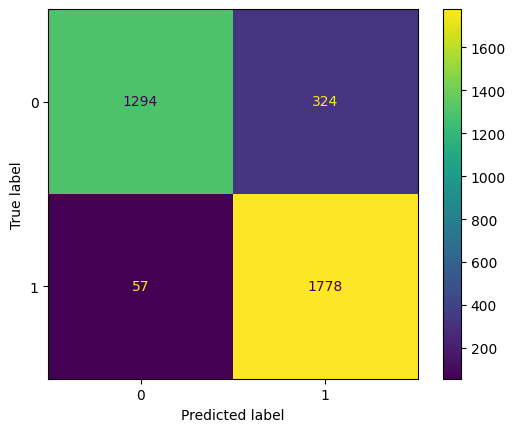

In [52]:
predictions = bagging.predict(test_set)

cm = confusion_matrix(test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

### ROC-Curve

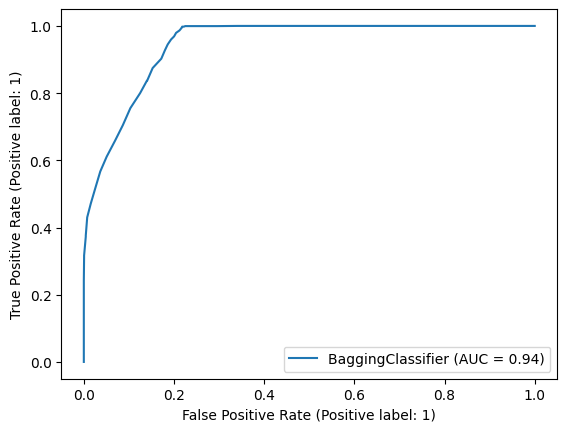

In [53]:
RocCurveDisplay.from_estimator(bagging, test_set, test_label)
plt.show()

### PCA Blobs

In [54]:
pca = PCA(n_components=2)
test_set_reduced = pca.fit_transform(test_set.values)

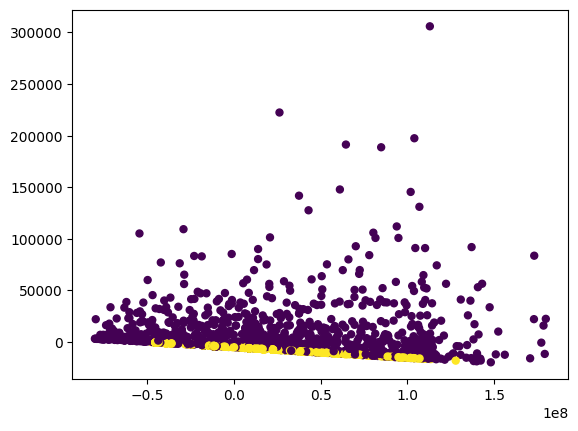

In [55]:
#true labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_label, s=25);

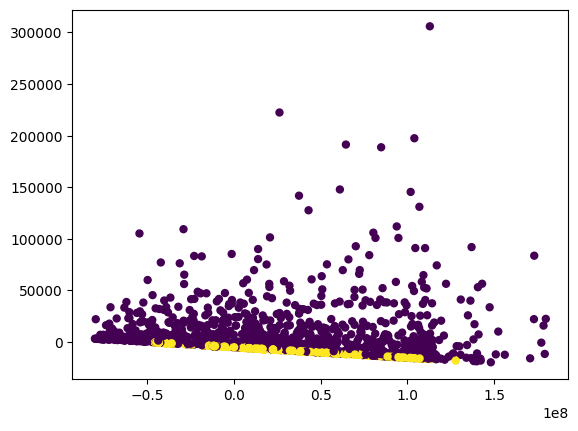

In [56]:
#predicted labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_pred, s=25);

## AdaBoost

In [57]:
param_grid = {'n_estimators': np.arange(5, 100, 5),
              'learning_rate': [0.8, 0.9, 1.0, 1.1, 1.2],
              'algorithm': ['SAMME', 'SAMME.R'],
             }

ada = AdaBoostClassifier()

grid = GridSearchCV(
    ada,
    param_grid,
    cv=3,
    scoring='accuracy',
    return_train_score=False,
    verbose=1,
    n_jobs=-1
)

grid.fit(train_set, train_label)

Fitting 3 folds for each of 190 candidates, totalling 570 fits


GridSearchCV(cv=3, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.8, 0.9, 1.0, 1.1, 1.2],
                         'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])},
             scoring='accuracy', verbose=1)

In [58]:
ada = grid.best_estimator_
ada

AdaBoostClassifier(learning_rate=0.9, n_estimators=40)

## Print Metrics

In [59]:
train_pred = ada.predict(train_set)
test_pred = ada.predict(test_set)

print_metrics(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.8983240223463688
Accuracy test set  0.8922675933970461
Precision train set  0.9117413566525497
Recall train set  0.8983240223463688
F1 score train set  0.8968130780754575
Support train set  (array([0.98842975, 0.84413519]), array([0.79226285, 0.99182434]), array([0.87954111, 0.91203952]), array([3774, 4281], dtype=int64))


In [60]:
report_scores(test_label,test_pred)

              precision    recall  f1-score   support

        <=50       0.98      0.78      0.87      1618
         >50       0.84      0.99      0.91      1835

    accuracy                           0.89      3453
   macro avg       0.91      0.89      0.89      3453
weighted avg       0.91      0.89      0.89      3453



### Confusion Matrix

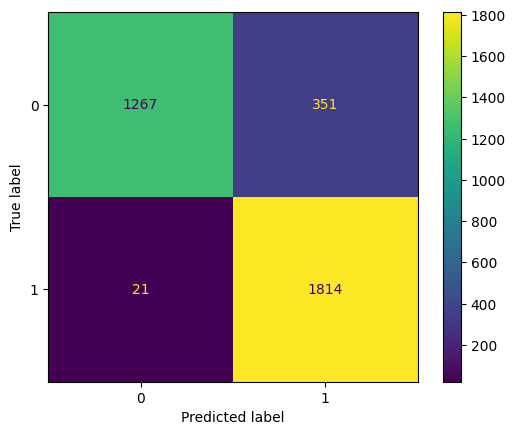

In [61]:
predictions = ada.predict(test_set)

cm = confusion_matrix(test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

### ROC-Curve

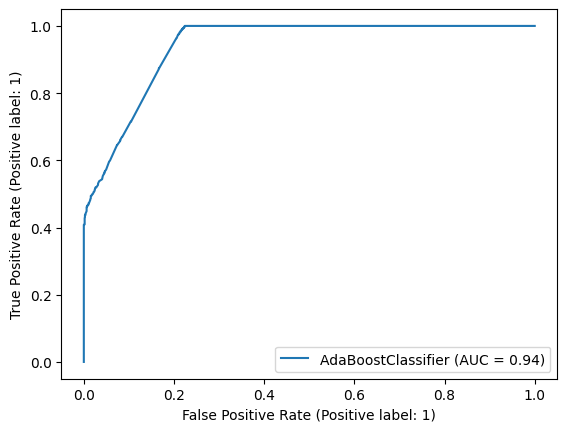

In [62]:
RocCurveDisplay.from_estimator(ada, test_set, test_label)
plt.show()

### PCA Blobs

In [63]:
pca = PCA(n_components=2)
test_set_reduced = pca.fit_transform(test_set.values)

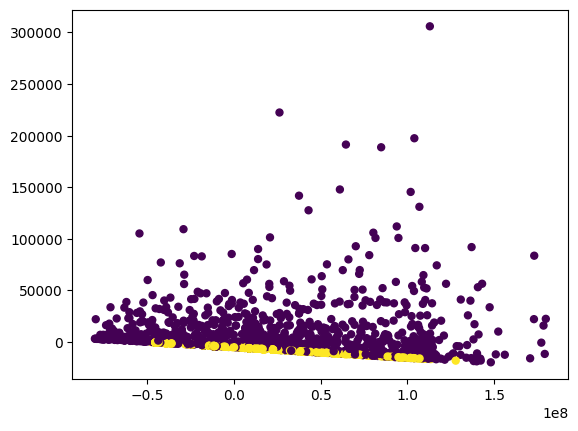

In [64]:
#true labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_label, s=25);

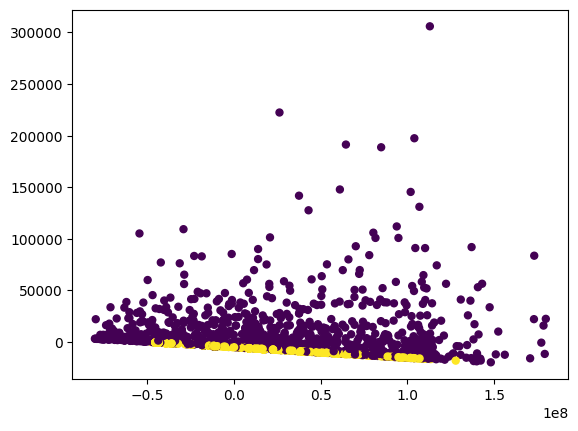

In [65]:
#predicted labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_pred, s=25);

## Save models

In [66]:
with open("../models_checkpoints/bagging_no_lang.bin", "wb") as f:
    pickle.dump(bagging, f)
    
with open("../models_checkpoints/adaboost_no_lang.bin", "wb") as f:
    pickle.dump(ada, f)